In [1]:
from util.gen_utils import *
from util.qc_util import *

import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

# Load raw data

In [2]:
discovery_data  = {'rnaseq' : rnaseq_data(counts_df_path = '../../data/rnaseq_discovery_data/htseq_merged.csv'),
              'sample_meta' : read_sample_meta_table('../../data/rnaseq_discovery_data/init_sample_data.csv'),
              'subj_meta' : read_sample_meta_table('../../data/rnaseq_discovery_data/init_subj_data.csv')
             }

validation_data  = {'rnaseq' : rnaseq_data(counts_df_path = '../../data/rnaseq_validation_data/htseq_merged.csv'),
              'sample_meta' : read_sample_meta_table('../../data/rnaseq_validation_data/val_sample_data.csv'),
              'subj_meta' : read_sample_meta_table('../../data/rnaseq_validation_data/val_subj_data.csv')
             }

# ID outlier samples
* Based on QC metrics
    * QC measures:
        1. Sample degradation
        2. Ribosomal fraction of reads
        3. Possible DNA contamination (DNAse used but regardless)

In [3]:
#Discovery QC
os.system('python util/id_outliers.py "../../data/qc_data/discovery_ribo_frac.txt" "../../data/qc_data/discovery_deg_3prime_bias_frac_1.txt" "../../data/qc_data/discovery_intron_exon_ratios.txt" \
          "out/discovery_qc/" --cutoffs_file "util/outlier_cutoffs_percentile95.txt"')

#Validation QC, Omit ribosomal RNA control since used for validation only
os.system('python util/id_outliers.py "../../data/qc_data/validation_ribo_frac.txt" "../../data/qc_data/validation_deg_3prime_bias_frac_1.txt" "../../data/qc_data/validation_intron_exon_ratios.txt" \
          "out/validation_qc/" --cutoffs_file "util/outlier_cutoffs_percentile95.txt" --outliers_to_include "intron,deg"')

0

In [4]:
discovery_data['qc'] = read_qc_data("out/discovery_qc/outlier_data.txt")
validation_data['qc'] = read_qc_data("out/validation_qc/outlier_data.txt")

# Visualize QC data 
* Use heatmap to visualize whether outlier samples cluster separately
* Use PCA to visualize logCPM values pre and post outlier sample filtering

Discovery dataset
7151 genes (Fraction = 0.117780) passed cutoff
117 samples (0.700599) passed QC
Validation dataset
5038 genes (Fraction = 0.082978) passed cutoff
41 samples (0.611940) passed QC


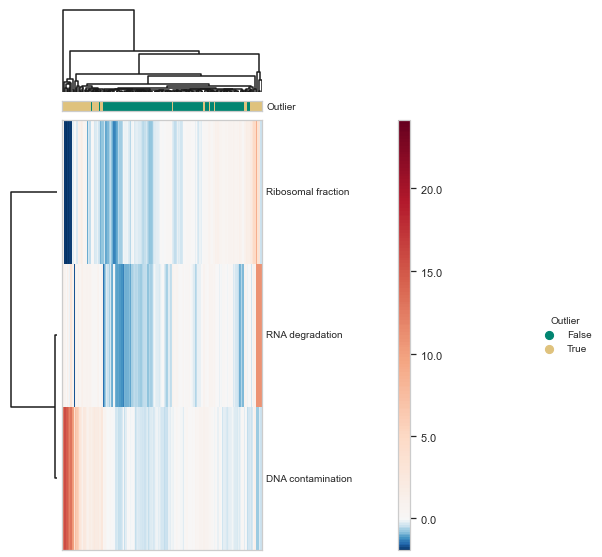

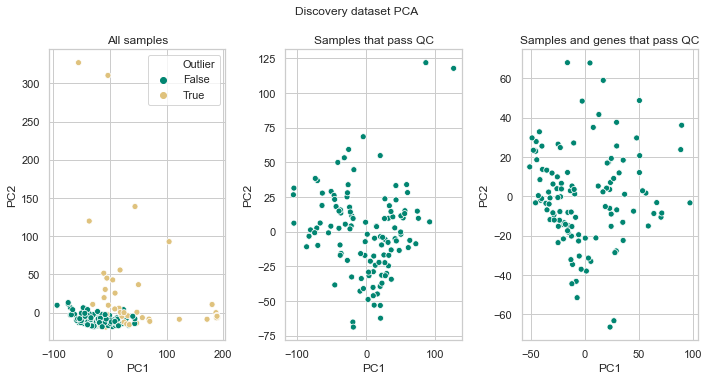

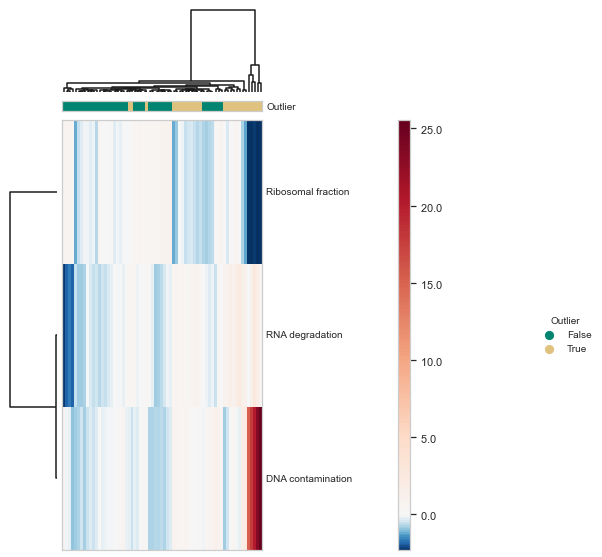

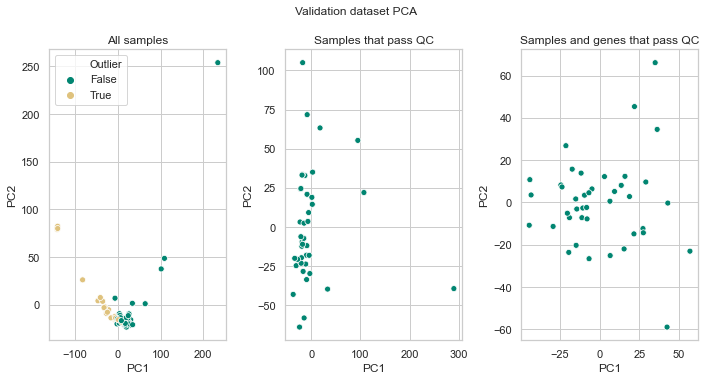

In [5]:
qc_out = {}

for dataset, data_tuple in {'Discovery dataset' : (discovery_data, "out/discovery_qc/plots/"), 
                                      'Validation dataset' : (validation_data, "out/validation_qc/plots/")}.items():
    data, plot_save_path = data_tuple
    qc_out[dataset] = {}
    
    print(dataset)
    qc_out[dataset]['samples_passed_qc'] = data['qc'].loc[~(data['qc'].Outlier)].index
    qc_out[dataset]['gene_qc_mask'] = filter_genes_CPMcutoff(data['rnaseq'].CPM.loc[:, qc_out[dataset]['samples_passed_qc']], CPM_cutoff = 0.5, frac_samples_exp = 0.75)
    qc_out[dataset]['heatmap'], qc_out[dataset]['pca'] = pca_and_viz_qc(data['qc'], data['rnaseq'].logCPM, qc_out[dataset]['gene_qc_mask'], dataset + " PCA")
    
    save_figure_pdf(qc_out[dataset]['heatmap'], plot_save_path + "heatmap.pdf")
    save_figure_pdf(qc_out[dataset]['pca'], plot_save_path + "pca.pdf")

# Filter data based on QC and save clean data
* Add term column: Split into time groups based on gestational age sampling scheme 
    * Groups are approx based on trimesters; however, scheduling can sometimes result in 2 samples in the same term but weeks apart.
    * Split below tries to keep samples within same 1-2 month period 
* Remove samples and genes that failed QC from counts tables and save clean table
    * Will use these to estimate TMM normalization and for analysis here on out
* Remove samples that failed QC from metadata tables, combine tables, and save
    * Will use these for analysis here on out

In [6]:
for dataset, data_tuple in {'Discovery dataset' : (discovery_data, "../../data/rnaseq_discovery_data/"), 
                                      'Validation dataset' : (validation_data, "../../data/rnaseq_validation_data/")}.items():
    data, save_path = data_tuple
    
    print(dataset)
    
    #Remove samples failed QC, get term data, get early v late onset
    data['sample_meta'] = data['sample_meta'].loc[qc_out[dataset]['samples_passed_qc']]
    data['sample_meta'].insert(0, 'term', get_term_labels(data['sample_meta'], 'ga_at_collection'))

    #Join sample + subj meta, add PE type, and save
    data['sample_meta_full'] = data['sample_meta'].join(data['subj_meta'], on = 'subject', how = 'inner')
    data['sample_meta_full'].insert(data['sample_meta_full'].shape[1], 'pe_type', get_pe_type(data['sample_meta_full']))
    data['sample_meta_full'].to_csv(save_path + 'sample_meta_postQC.csv')
    
    #Clean up counts table
    counts_clean = data['rnaseq'].counts.loc[qc_out[dataset]['gene_qc_mask'], qc_out[dataset]['samples_passed_qc']]
    counts_clean.to_csv(save_path + 'htseq_postQC.csv')
    
    #Print quick stats about data
    print(data['sample_meta_full'].groupby(['group', 'term']).count().iloc[:, 0])
    print('Counts table now has %d genes and %d samples' % counts_clean.shape)

Discovery dataset
group    term
Control  1       13
         2       16
         3       12
         4       14
PE       1       12
         2       15
         3       19
         4       16
Name: subject, dtype: int64
Counts table now has 7151 genes and 117 samples
Validation dataset
group    term
Control  1       4
         2       8
         3       2
         4       5
PE       1       3
         2       8
         3       6
         4       5
Name: subject, dtype: int64
Counts table now has 5038 genes and 41 samples
